<h1>Scene Classification using the UC Merced Land Use Dataset</h1>

Author: Vaasudevan Srinivasan <br>
Created on: July 31, 2021

Dataset: http://weegee.vision.ucmerced.edu/datasets/landuse.html

# Downloading the Dataset

In [ ]:
%%capture

!pip install -q split-folders
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -qq UCMerced_LandUse.zip

In [ ]:
# Look at the folders within the dataset
!ls UCMerced_LandUse/Images

agricultural	 denseresidential  mediumresidential  sparseresidential
airplane	 forest		   mobilehomepark     storagetanks
baseballdiamond  freeway	   overpass	      tenniscourt
beach		 golfcourse	   parkinglot
buildings	 harbor		   river
chaparral	 intersection	   runway


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import splitfolders

tf.__version__

'2.5.0'

# Image Generators and Visualization

In [ ]:
# Split the dataset into 80% training, 10% validation and 10% testing
splitfolders.ratio('UCMerced_LandUse/Images',
                   output='dataset',
                   seed=1337,
                   ratio=(0.8, 0.1, 0.1))

Copying files: 2100 files [00:05, 356.10 files/s]


In [ ]:
datagen = ImageDataGenerator()
train_ds = datagen.flow_from_directory('dataset/train', batch_size=64, seed=123)
val_ds = datagen.flow_from_directory('dataset/val', seed=123)
test_ds = datagen.flow_from_directory('dataset/test', seed=123)

Found 1680 images belonging to 21 classes.
Found 210 images belonging to 21 classes.
Found 210 images belonging to 21 classes.


# Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

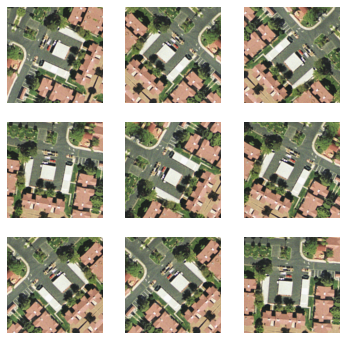

In [ ]:
image = train_ds.next()[0][0]

plt.figure(figsize=(6, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Model Training

In [ ]:
base_model = EfficientNetB7(include_top=False, weights='imagenet')
base_model.trainable=False

# Building the model
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(21, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Training the model
model.compile(optimizer='adam', metrics=['accuracy'],
              loss='categorical_crossentropy')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 21)                53781     
Total params: 64,151,468
Trainable params: 53,781
Non-trainable params: 64,097,687
____________________________________________

In [ ]:
h = model.fit(x=train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
27/27 [==============================] - 53s 1s/step - loss: 2.1304 - accuracy: 0.5250 - val_loss: 1.2667 - val_accuracy: 0.8286
Epoch 2/10
27/27 [==============================] - 25s 945ms/step - loss: 0.9711 - accuracy: 0.8310 - val_loss: 0.7449 - val_accuracy: 0.8667
Epoch 3/10
27/27 [==============================] - 26s 974ms/step - loss: 0.6326 - accuracy: 0.8893 - val_loss: 0.5693 - val_accuracy: 0.8952
Epoch 4/10
27/27 [==============================] - 26s 959ms/step - loss: 0.5073 - accuracy: 0.8994 - val_loss: 0.4866 - val_accuracy: 0.8905
Epoch 5/10
27/27 [==============================] - 26s 965ms/step - loss: 0.4138 - accuracy: 0.9119 - val_loss: 0.4313 - val_accuracy: 0.8905
Epoch 6/10
27/27 [==============================] - 26s 969ms/step - loss: 0.3518 - accuracy: 0.9327 - val_loss: 0.3924 - val_accuracy: 0.9000
Epoch 7/10
27/27 [==============================] - 26s 966ms/step - loss: 0.3212 - accuracy: 0.9423 - val_loss: 0.3537 - val_accuracy: 0.9000
Ep

In [ ]:
model.evaluate(test_ds)

7/7 [==============================] - 3s 413ms/step - loss: 0.7342 - accuracy: 0.8619


[0.7341892719268799, 0.8619047403335571]